# AutoEncoders for Anomaly Detection tutorial using BioExcel Building Blocks (biobb)

This tutorial involves the use of a **multilayer AutoEncoder (AE)** for **feature extraction** and **pattern recognition** by analyzing **Molecular Dynamic Simulations**, step by step, using the **BioExcel Building Blocks library (biobb)**.

***

**MD Simulations:**

**MD simulations** were obtained from the [MDDB Database](https://mmb-dev.mddbr.eu/)
* **Replicase polyprotein 1ab** (PDB: [6W9C](https://www.rcsb.org/structure/6W9C)):
   1. **apo form**    (No ligands)
   2. **holo form** (Ligand: [3KB](https://www.rcsb.org/ligand/3KB)).

Only the **alpha-carbons** were selected for both cases.

**Data Preparation**

* **Input Data**: The input to the AE is a **2D vector**. The trajectory [num_frames, num_atoms, xyz_coordinates] is flattened to a 2D vector [num_frames, num_features], where the num_features is the result of flattening the num_atoms and the xyz coordinates dimensions ([num_frames, num_atoms*xyz_coordinates]).
* **Input Data normalization**: The data undergoes **min-max normalization** to ensure consistent scale across all features.
* **Training/Validation splitting**: The **dataset** is **divided** into **training** and **validation sets**, comprising 80% and 20% of the data, respectively.

**AutoEncoder Structure**

**AutoEncoder (AE)**: An **unsupervised neural network** used for **dimensionality reduction**, **feature extraction** and **pattern/anomaly recognition**.
* **Architecture**: AE with **symmetrical** encoder and decoder networks.
  * **Encoder**: Neurons decrease from the number of features to the latent space in an even rate using the **step size function** (see below).  
     * **Activation Function**: **LeakyRelu** (Hidden Layers), **Sigmoid** (for the Last Layer).
     * **Dropout** (default = 0)
  * **Latent Space**
  * **Decoder**: Neurons increase from the number of features to the latent space in an even rate using the **step size function** (see below).  
     * **Activation Function**: **LeakyRelu** (Hidden Layers), **Sigmoid** (for the Last Layer).
     * **Dropout** (default = 0)

**Node Steps Size function:**

$$ \delta = \frac{{{n_{features}} - {z_{dim}}}}{{{n_{layers} + 1}}} $$
where,
* $n_{features}$ is the number of features of the input data
* $z_{dim}$ is the latent space dimensions
* $n_{layers}$ is the number of layers in the encoder or decoder

**Loss Function:** 

The AE is trained to reconstruct the input data. It learns to minimize the **mean squared error (MSE)** between the original input and the reconstructed output.

$$ \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $$
where,
* $n$ is the number of snapshots.
* $y_i$ is the actual value for the i-th snapshots.
* $\hat{y}_i$ is the predicted value for the i-th snapshots

***


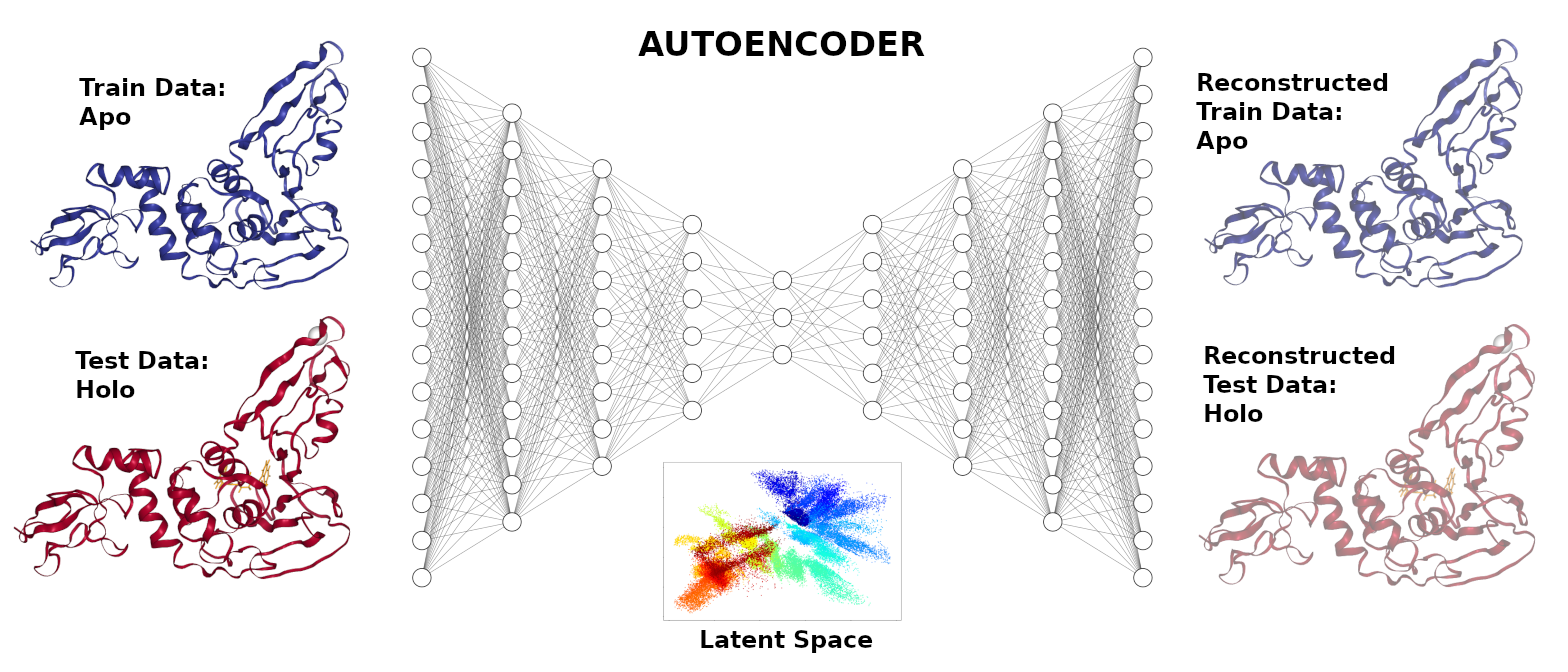

***
## Settings

### Biobb modules used

* [biobb_pytorch](https://github.com/bioexcel/biobb_pytorch): module collection to create and train ML & DL models using the popular PyTorch Python library.

### Auxiliary libraries used

* [jupyter](https://jupyter.org/): Free software, open standards, and web services for interactive computing across all programming languages.
* [nglview](http://nglviewer.org/#nglview): Jupyter/IPython widget to interactively view molecular structures and trajectories in notebooks.
* [numpy](https://numpy.org/): The fundamental package for scientific computing with Python.
* [mdtraj](https://www.mdtraj.org/): Read, write and analyze MD trajectories with only a few lines of Python code.
* [requests](https://requests.readthedocs.io/en/latest/): Requests is an elegant and simple HTTP library for Python, built for human beings.
* [matplotlib](https://matplotlib.org/): Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python.

> **IMPORTANT**: if your computer is a **mac ARM**, please be sure that the chosen architecture in conda is **ARM**. If not sure, type the following instruction in your terminal **before** starting the creation of the **environment**: <br>
`conda config --env --set subdir osx-arm64` <br>
This instruction ensures that the installed **torch** dependency will match your **architecture**. 

### Conda Installation and Launch

```console
git clone https://github.com/bioexcel/biobb_wf_autoencoder.git
cd biobb_wf_autoencoder
conda env create -f conda_env/environment.yml
conda activate biobb_wf_autoencoder
jupyter-notebook biobb_wf_autoencoder/notebooks/biobb_wf_autoencoder.ipynb
```

***
## Pipeline steps
 1. [Input Parameters](#input)
 2. [Downloading trajectory and structure](#downloading)
 3. [Model Hyperparameters](#model-hyperparameters)
 4. [Train Model](#train-model)
 5. [Apply Model](#apply-model)
    1. [Analyze Training Performance](#analyse-training-performance)
    2. [Case Study: Comparing Apo vs Holo conditions](#case-study-comparing-apo-vs-holo-conditions)
 6. [Questions & Comments](#questions)
 
***
<img src="https://bioexcel.eu/wp-content/uploads/2019/04/Bioexcell_logo_1080px_transp.png" alt="Bioexcel2 logo"
	title="Bioexcel2 logo" width="400" />
***


## Initializing colab
The two cells below are used only in case this notebook is executed via Google Colab.

In [10]:
# Only executed when using Google Colab
import sys
if 'google.colab' in sys.modules:
  import subprocess
  from pathlib import Path
  import os
  try:
    subprocess.run(["conda", "-V"], check=True)
  except FileNotFoundError:
    # Install Anaconda
    subprocess.run([sys.executable, "-m", "pip", "install", "condacolab"], check=True)
    import condacolab
    condacolab.install()
    # Clone repository
    repo_URL = "https://github.com/bioexcel/biobb_wf_autoencoder.git"
    repo_name = Path(repo_URL).name.split('.')[0]
    if not Path(repo_name).exists():
      subprocess.run(["mamba", "install", "-y", "git"], check=True)
      subprocess.run(["git", "clone", repo_URL], check=True)
      print("⏬ Repository properly cloned.")
    # Install environment
    print("⏳ Creating environment...")
    env_file_path = f"{repo_name}/conda_env/environment.yaml"
    subprocess.run(["mamba", "env", "update", "-n", "base", "-f", env_file_path], check=True)
    print("🎨 Install NGLView dependencies")
    subprocess.run(["mamba", "install", "-y", "-c", "conda-forge", "nglview==3.0.8", "ipywidgets=7.7.2"], check=True)
    print("👍 Conda environment successfully created and updated.")
    # Only for torch workflows
    try:
      import torch
      print("💡 Installing Torch Google Colab compatible version.")
      subprocess.run(["mamba", "remove", "--force-remove", "-y", "pytorch"], check=True)
      subprocess.run([sys.executable, "-m", "pip", "install", "torch==2.2.1"], check=True)
    except ImportError:
      pass

In [ ]:
# Enable widgets for colab and change dir
import sys
import subprocess
from pathlib import Path
import os
try:
  import torch
  if torch.cuda.is_available():
    print("🐇 Torch CUDA is available!")
  else:
    print("🐢 Torch Running in CPUs")
except ImportError:
    pass
if 'google.colab' in sys.modules:
  from google.colab import output
  output.enable_custom_widget_manager()
  # Change working dir
  repo_URL = "https://github.com/bioexcel/biobb_wf_autoencoder.git"
  repo_name = Path(repo_URL).name.split('.')[0]
  os.chdir(f"{repo_name}/{repo_name}/notebooks")
  print(f"📂 New working directory: {os.getcwd()}")

***
<a id="input"></a>
## Input parameters

**Input parameters** needed:
  - **Training Data**:
    - **trj_in**: Path to input XTC trajectory file.
    - **str_in**: Path to input PDB topology file. 
  - **Testing Data**:
    - **test_trj_in**: Path to input XTC trajectory file.
    - **test_str_in**: Path to input PDB topology file.


In [12]:
# Importing libraries
import numpy as np
import mdtraj as md
import nglview as nv
import biobb_pytorch
from biobb_pytorch.mdae import plots
import requests
from pathlib import Path

# Trajectory and structure files for training
trj_in = "trajs/6W9C_apo.xtc"
str_in = "trajs/6W9C_apo.pdb"

# Trajectory and structure files for testing
test_trj_in = "trajs/6W9C_holo.xtc"
test_str_in = "trajs/6W9C_holo.pdb"

***
<a id="downloading"></a>
## Downloading trajectory and structure

**Downloading** the **trajectory** and **structure** for **Training**.

Trajectories where obtained from the [MDDB database](https://mmb-dev.mddbr.eu/#/).


In [33]:
# Downloading trajectory and structure for training
traj_train_URL = "https://mmb-dev.mddbr.eu/api/rest/v1/projects/MCV1900210/trajectory?format=xtc&frames=1-10000&selection=backbone%20and%20.CA"
pdb_train_URL = "https://mmb-dev.mddbr.eu/api/rest/v1/projects/MCV1900210/structure?selection=backbone%20and%20.CA"
traj_train_path = trj_in
structure_train_path = str_in
Path(traj_train_path).parent.mkdir(parents=True, exist_ok=True)
req = requests.get(traj_train_URL, allow_redirects=True)
open(traj_train_path, 'wb').write(req.content)
req = requests.get(pdb_train_URL, allow_redirects=True)
open(structure_train_path, 'wb').write(req.content)

# Load trajectory
train_traj = md.load(traj_train_path, top=structure_train_path)

**Downloading** the **trajectory** and **structure** for **testing**.

Trajectories where obtained from the [MDDB database](https://mmb-dev.mddbr.eu/#/).


In [14]:
# Downloading trajectory and structure for testing
traj_URL = "https://mmb-dev.mddbr.eu/api/rest/v1/projects/MCV1900212/trajectory?format=xtc&frames=1-10000&selection=backbone%20and%20.CA"
pdb_URL = "https://mmb-dev.mddbr.eu/api/rest/v1/projects/MCV1900212/structure?selection=backbone%20and%20.CA"
Path(test_trj_in).parent.mkdir(parents=True, exist_ok=True)
req = requests.get(traj_URL, allow_redirects=True)
open(test_trj_in, 'wb').write(req.content)
req = requests.get(pdb_URL, allow_redirects=True)
open(test_str_in, 'wb').write(req.content)

# Load trajectory
test_traj = md.load(test_trj_in, top=test_str_in)

### Visualizing 3D structure
Visualizing the **trajectory** using **NGL**:

In [ ]:
# Show trajectory
view = nv.show_mdtraj(train_traj)
view

Visualizing the **testing trajectory** using **NGL**:

In [ ]:
# Show trajectory
view = nv.show_mdtraj(test_traj)
view

***
## Model Hyperparameters

**Model hyperparameters** needed:

* **partition** *(float)* : Percentage selected of data as the training partition. 
* **batch_size** *(int)* :  Number of samples of the dataset per batch toload. It is the number of training examples utilized in one iteration. 
* **latent_dimensions** *(int)* : Number of dimensions of the latent space. It is a representation of compressed data in a low-dimensional space. 
* **num_layers** *(int)* : Number of layers in both encoder and decoder neural networks, excluding the layer of the latent space and the output layer. 
* **lr** *(float)* : Learning rate used for the Adam optimizer. Step size in optimization for each iteration during training.
* **num_epochs** *(int)* : Number of epochs required for model training.
* **normalize** *(Boolean)* : Normalize the input data.
* **lr_step_size** *(int)* : Period of learning rate decay.
* **gamma** *(float)* : Multiplicative factor of learning rate decay. 
* **leakyrelu** *(float)* : Controls the angle of the negative slope of the LeakyReLu activation function. 
* **dropout** *(float)* : Probability of an element/neuron to be zeroed. 


In [30]:
# Model Hyperparameters
batch_size = 8
nlayers = 4
epochs = 100
lr = 0.0004
partition = 0.8
latent_dim = 3
lr_step_size = 100
gamma = 0.0
dropout = 0.38
leaky_relu = 0.49

prop = {
    "latent_dimensions": latent_dim,
    "num_layers": nlayers,
    "batch_size": batch_size,
    "num_epochs": epochs,
    "lr": lr,
    "lr_step_size": lr_step_size,
    "gamma": gamma,
    "partition": partition,
    "log_interval": 1,
    "seed": 42
    }

***
## Train Model

**Biobb modules** used:
* [biobb_pytorch](https://github.com/bioexcel/biobb_pytorch)

**Input parameters** needed:
- **input_train_npy_path**: Path to the NPY trajectory file.
- **output_model_pth_path**: Path where trained model will be saved.
- **output_train_data_npz_path**: Path where training output data will be saved.
- **output_performance_npz_path**: Path where training performance output data will be saved.


In [ ]:
# Input files
input_train_npy_path = "trajs/6W9C_apo.npy"   # Training data
np.save(input_train_npy_path, train_traj.xyz) # Save the trajectory as a numpy array

# Output files
output_model_pth_path = "model.pth"
output_train_data_npz_path = "train_data.npz"
output_performance_npz_path = "performance.npz"

# Train MD-AE
biobb_pytorch.mdae.train_mdae.trainMDAE(input_train_npy_path=input_train_npy_path,
                                        output_model_pth_path=output_model_pth_path,
                                        output_train_data_npz_path=output_train_data_npz_path,
                                        output_performance_npz_path=output_performance_npz_path,
                                        properties=prop)

### Visualizing the Learning Process

Plot of the **training** and **validation loss** with respect to the **epoch number** during autoencoder **training**.

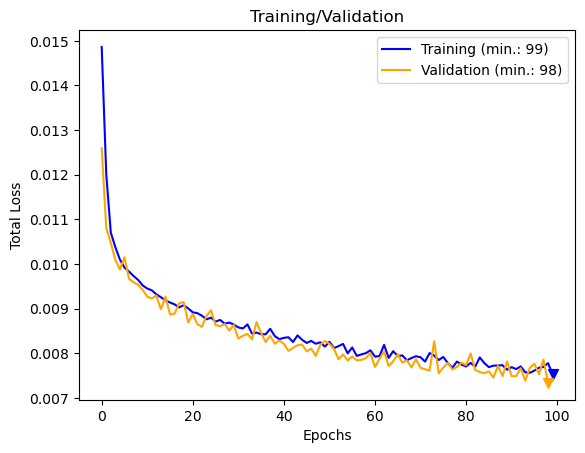

In [19]:
plots.plot_loss(output_train_data_npz_path=output_train_data_npz_path)

***
## Apply Model

**Biobb modules** used:
* [biobb_pytorch](https://github.com/bioexcel/biobb_pytorch)


### Analyze Training Performance

**Input parameters** needed:
- **output_reconstructed_train_npy_path**: Path of reconstructed training data is saved in npy format.
- **output_train_latent_space_npy_path**: Path of latent space representation of the training data is saved in npy format.

In [20]:
# Output files
output_reconstructed_train_npy_path = "reconstructed_train_data.npy"
output_train_latent_space_npy_path = "train_latent_space.npy"

prop = {
    "latent_dimensions": latent_dim,
    "num_layers": nlayers,
    "batch_size": batch_size,
    }

biobb_pytorch.mdae.apply_mdae.applyMDAE(input_data_npy_path=input_train_npy_path,
                                        input_model_pth_path=output_model_pth_path,
                                        output_reconstructed_data_npy_path=output_reconstructed_train_npy_path,
                                        output_latent_space_npy_path=output_train_latent_space_npy_path,
                                        properties=prop)

2024-06-12 20:54:22,974 [MainThread  ] [INFO ]  Executing biobb_pytorch.mdae.apply_mdae Version: 4.2.1
2024-06-12 20:54:23,012 [MainThread  ] [INFO ]  Copy: trajs/6W9C_apo.npy to /home/pieter/Documents/PhD/AI/Models/AE/biobb_wf_autoencoders/biobb_wf_autoencoder/biobb_wf_autoencoder/notebooks/9d155599-38eb-41d1-bdfc-e495f594e294
2024-06-12 20:54:23,021 [MainThread  ] [INFO ]  Copy: model.pth to /home/pieter/Documents/PhD/AI/Models/AE/biobb_wf_autoencoders/biobb_wf_autoencoder/biobb_wf_autoencoder/notebooks/9d155599-38eb-41d1-bdfc-e495f594e294
2024-06-12 20:54:23,026 [MainThread  ] [INFO ]  Applying MDAE model reducing dimensionality from 936 to 3 and reconstructing.
2024-06-12 20:54:23,029 [MainThread  ] [INFO ]  Applying model:
2024-06-12 20:54:23,031 [MainThread  ] [INFO ]    Device: cpu
2024-06-12 20:54:23,033 [MainThread  ] [INFO ]    Input file: /home/pieter/Documents/PhD/AI/Models/AE/biobb_wf_autoencoders/biobb_wf_autoencoder/biobb_wf_autoencoder/notebooks/9d155599-38eb-41d1-bdfc-

0

#### Visualizing RSMD: Input vs Reconstruction Trajectories

The **Root Mean Square Deviation (RMSD)** comparison between **input** and **reconstructed trajectories** using the **autoencoder** quantitatively **evaluates** how accurately the autoencoder model captures and reconstructs the dynamic movements and structures from the input molecular simulation data. This analysis helps **assess the model's performance** by **comparing** the **input trajectory** with the **reconstructed trajectory** representation.


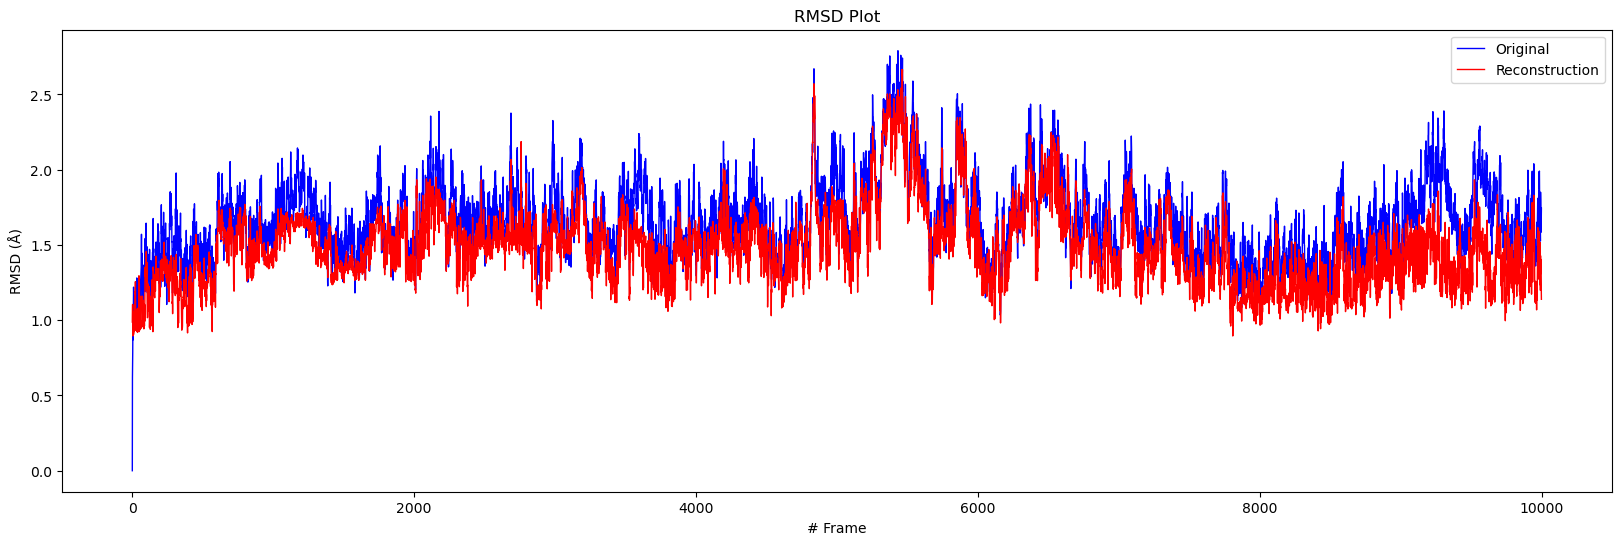

In [21]:
plots.plot_rmsd(traj_file_npy_path=input_train_npy_path, output_reconstructed_traj_npy_path=output_reconstructed_train_npy_path)

#### Visualizing RMSF: Input vs Reconstruction Trajectories

The **Root Mean Square Fluctuation (RMSF)** comparison between **input** and **reconstructed trajectories** using an **autoencoder** assesses the **variability of atomic positions over time**, indicating the model's ability to retain the dynamic conformational changes in molecular simulations. This analysis is crucial for **evaluating** how well the **autoencoder captures** the inherent **flexibility** and **motion** of the **molecular dynamic simulation**.

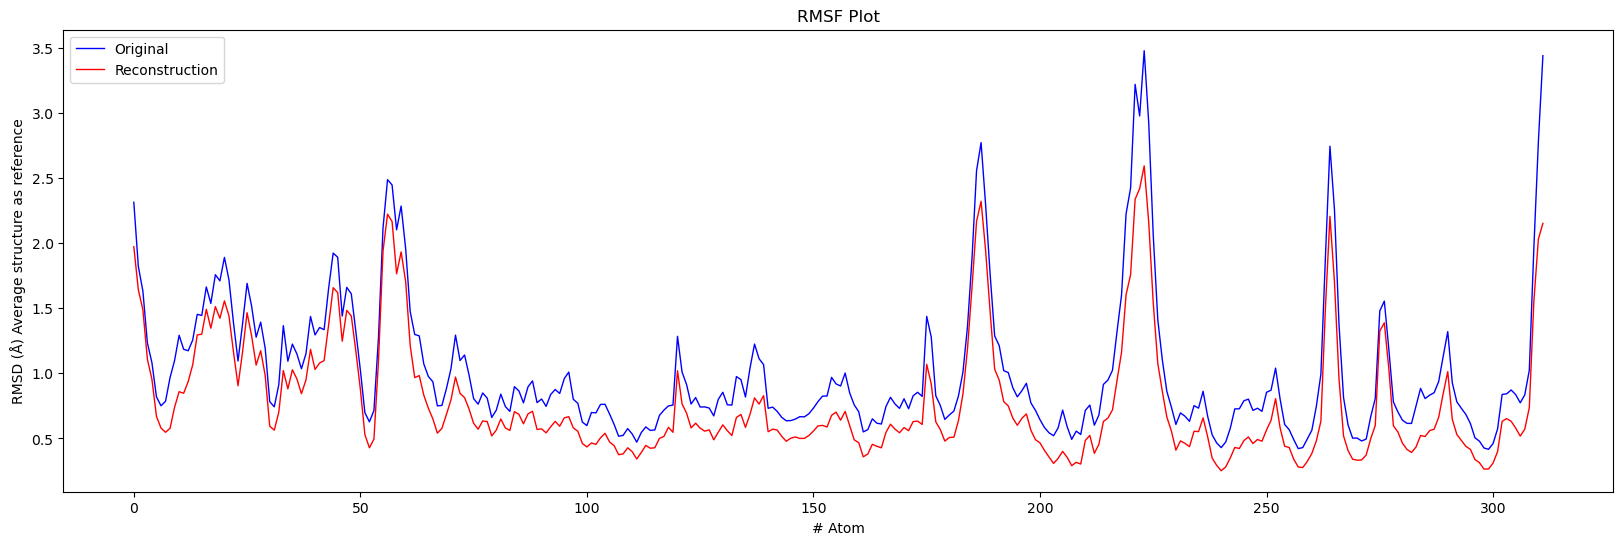

In [22]:
plots.plot_rmsf(original_traj_npy_file=input_train_npy_path, mutated_reconstructed_traj_npy_file=output_reconstructed_train_npy_path)

**RMSF difference plot** between **input** and **reconstructed trajectory** from an **autoencoder** visually **highlights** the **discrepancies** in **atomic fluctuations**, showcasing where the model may underrepresent or overrepresent the dynamic behavior of the **molecular dynamic simulation**. This comparison can pinpoint **specific areas** or **residues** of the structure that require improved modeling accuracy.

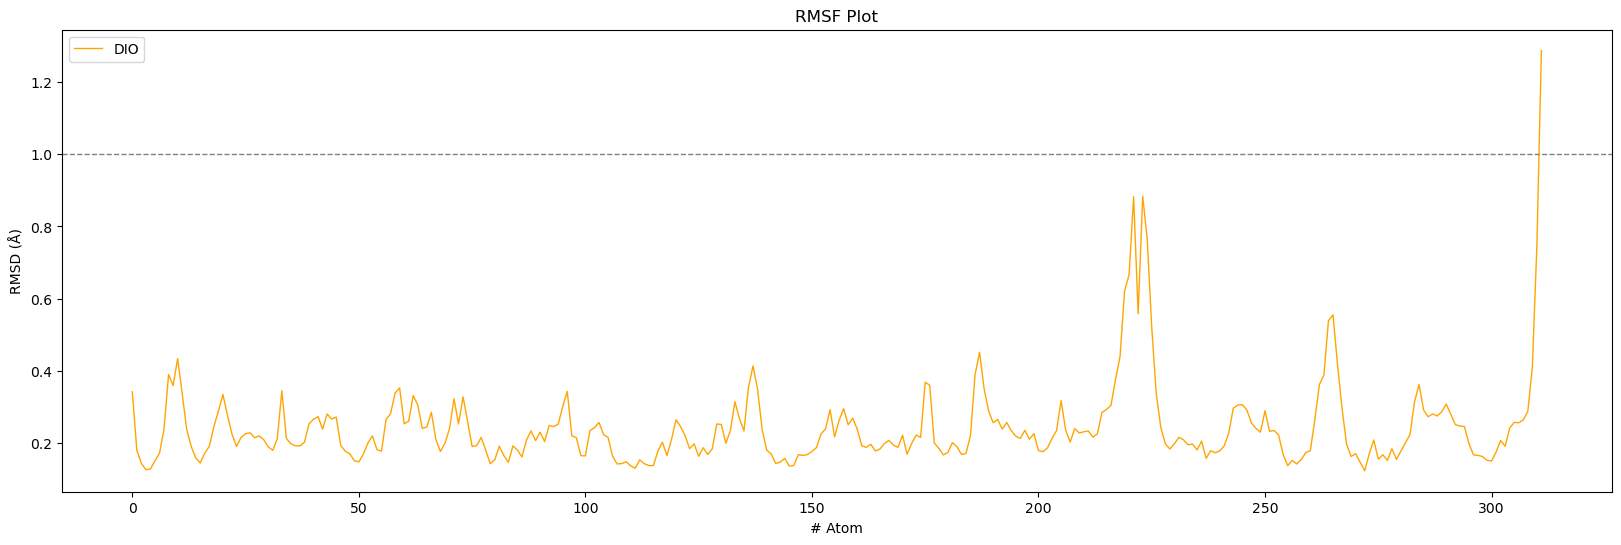

In [23]:
plots.plot_rmsf_difference(original_traj_npy_file=input_train_npy_path, mutated_reconstructed_traj_npy_file=output_reconstructed_train_npy_path)

#### Visualizing Latent Space Representation

The **2D latent space representation** of a dataset through an autoencoder visually condenses complex, **high-dimensional data** into **low-dimensional representation**. This reduced representation can reveal underlying structures and relationships within the data, essential for intuitive analysis and further scientific insights.

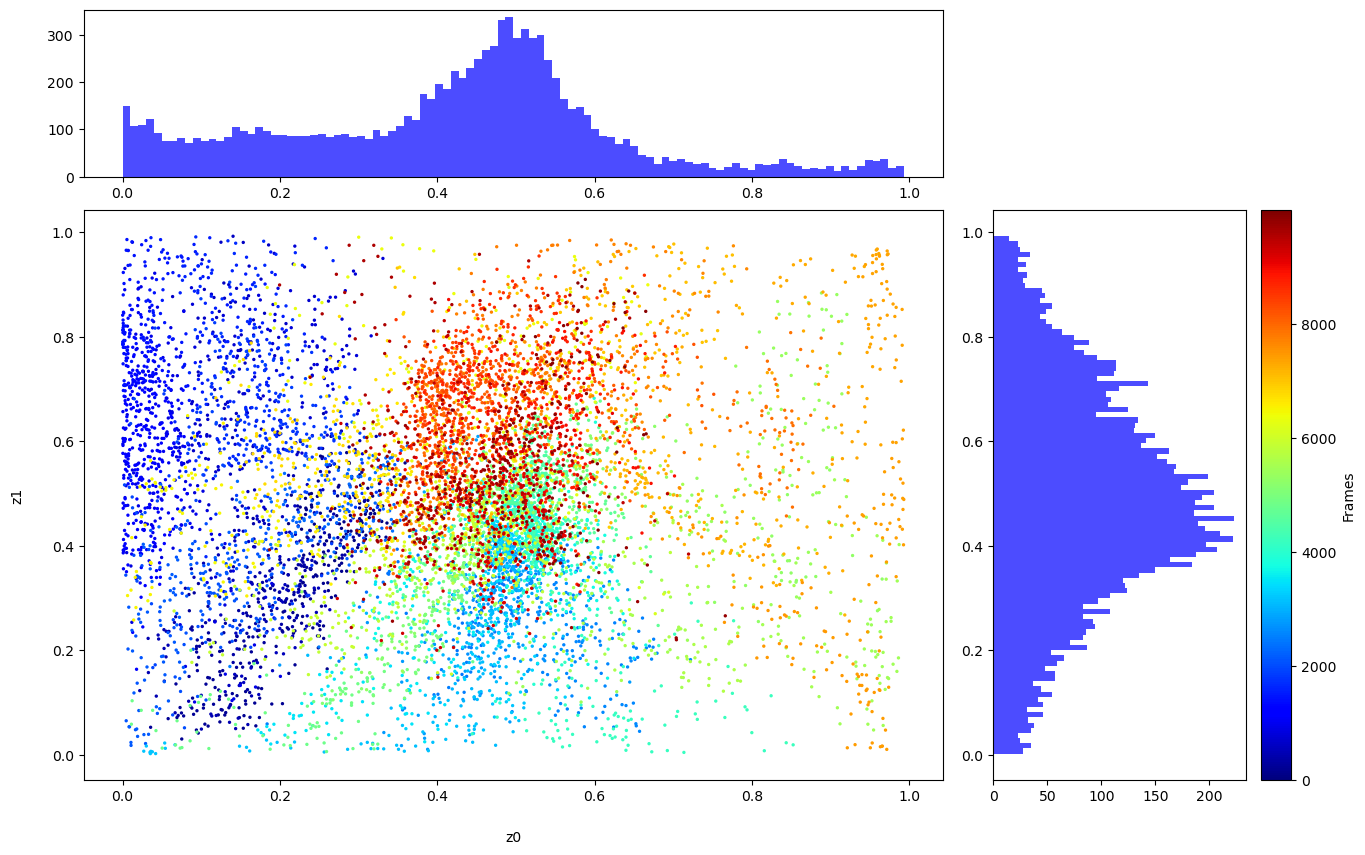

In [24]:
# Latent Space Representation
plots.plot_latent_space(latent_space_npy_path=output_train_latent_space_npy_path)

***
### Case Study: Comparing Apo vs Holo Conditions

This case study focuses on understanding the **dynamic behaviors** of **proteins** under two different conditions: **apo** (unbound) and **holo** (ligand-bound). The key metrics used for this analysis are **Root Mean Square Deviation (RMSD)** and **Root Mean Square Fluctuation (RMSF)**. These metrics provide **insights** into the **structural** and **dynamic** **changes** that occur when a **protein interacts** with a **ligand**.

The study involves **comparing** **input trajectories** versus **reconstructed trajectories** using the a**utoencoder model**, specifically within the context of **anomaly detection** in **protein dynamics**. The autoencoder model is **trained** exclusively on trajectories under the **apo condition**, where the protein is not bound to any ligands. This training setup enables the model to learn the **apo condition structural dynamics** of the unbound protein.

For **testing**, the model is presented with **holo condition trajectories**, where the protein is bound to a ligand. The key purpose here is to see how well the autoencoder, trained on apo condition data, can **reconstruct trajectories** from the **holo condition**. Discrepancies and deviations in the **reconstruction** can **reveal important insights** into the **structural dynamics** and **functional implications** of **ligand binding**, ***highlighting regions*** of the protein that may be particularly **affected** by **ligand interaction** or that exhibit **unexpected behaviors** in the **holo form**. 

#### Apply Model



**Input parameters** used:
- **output_reconstructed_npy_path**: Path of reconstructed testing data is saved in npy format.
- **output_latent_space_npy_path**: Path of latent space representation of the testing data is saved in npy format.


In [ ]:
# Input files
input_data_npy_path = "trajs/6W9C_holo.npy"
np.save(input_data_npy_path, test_traj.xyz) # Save the trajectory as a numpy array

# Output files
output_reconstructed_data_npy_path = "reconstructed_data.npy"
output_latent_space_npy_path = "latent_space.npy"

prop = {
    "latent_dimensions": latent_dim,
    "num_layers": nlayers,
    "batch_size": batch_size,
    }

biobb_pytorch.mdae.apply_mdae.applyMDAE(input_data_npy_path=input_data_npy_path,
                                        input_model_pth_path=output_model_pth_path,
                                        output_reconstructed_data_npy_path=output_reconstructed_data_npy_path,
                                        output_latent_space_npy_path=output_latent_space_npy_path,
                                        properties=prop)

#### Visualizing 3D Structure
Visualizing the **Reconstructed trajectory** using **NGL**:

In [ ]:
# Load trajectory
reconstructed_traj = md.load(test_trj_in, top=test_str_in)
reconstructed_traj.xyz = np.load(output_reconstructed_data_npy_path)

# Show trajectory
view = nv.show_mdtraj(reconstructed_traj)
view

#### Visualizing Trajectory Reconstruction RMSD

**Root Mean Square Deviation (RMSD)** is used to **compare** the **input** versus **reconstructed trajectories** using the **autoencoder model**, specifically within the context of **anomaly detection** in **protein dynamics**. 

**Significant RSMD values** indicate anomalies, **suggesting** that the h**olo condition** introduces **changes or features not learned** during the **apo condition training**. This method can effectively **highlight structural differences** and **anomalies** caused by **ligand binding**, providing insights into how binding affects **protein conformation** and **dynamics**.

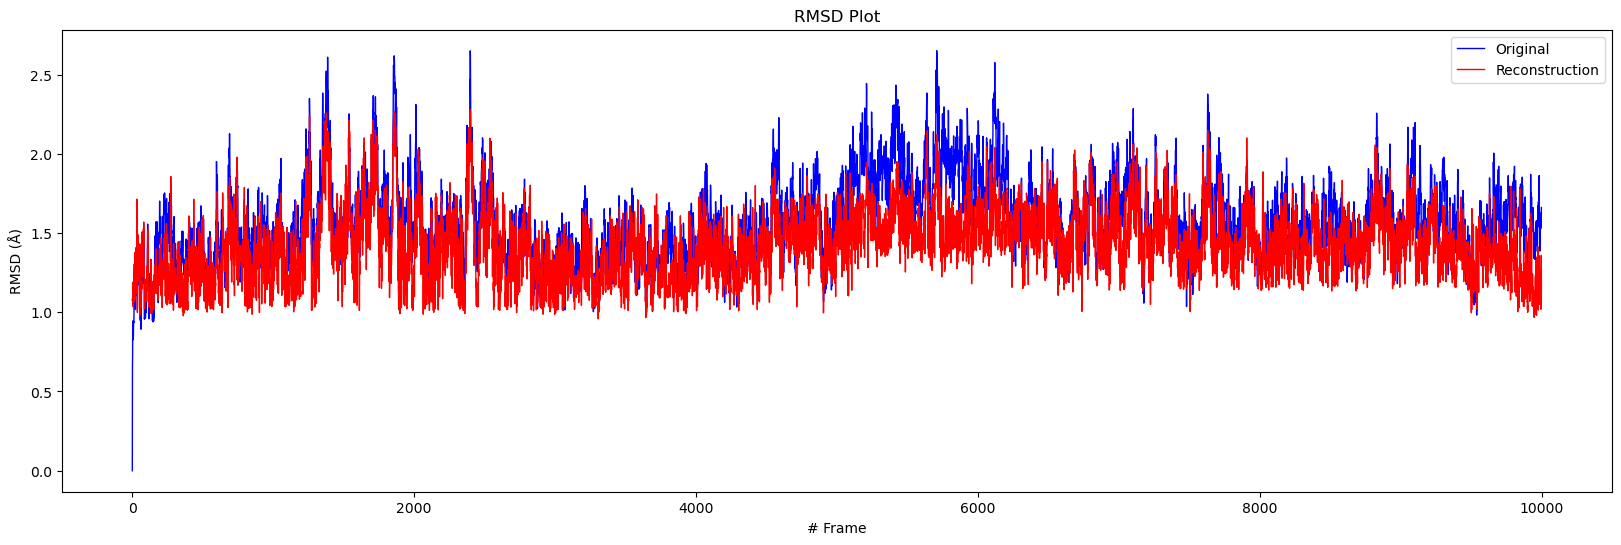

In [27]:
plots.plot_rmsd(traj_file_npy_path=input_data_npy_path, output_reconstructed_traj_npy_path=output_reconstructed_data_npy_path)

#### Visualizing Trajectory Reconstruction RMSF

**Root Mean Square Fluctuation (RMSF)** is used to **compare** **input** versus **reconstructed trajectories** using an **autoencoder model**. The **model** is **trained** on trajectory data from proteins in the **apo condition**, which means the proteins are studied without any bound ligands. 

The **input data** for the model, however, consists of trajectories from the **holo condition**, where proteins are observed with **bound ligands**. This setup is designed to explore the model's ability to reconstruct the **holo condition** based on learning from the **apo condition**, thereby testing the model’s generalization capabilities. The key focus is on **anomaly detection**, **identifying areas** where the **reconstructed holo trajectory** significantly **deviates** from the **input trajectory**. These deviations can **highlighting residues** or **atoms** of the protein that may be particularly affected by ligand interaction or that exhibit unexpected behaviors in the **holo form**. This approach not only aids in understanding protein-ligand interactions but also enhances the potential applications of autoencoders in biomolecular research, offering a novel way to detect and analyze anomalies in protein behavior under different conditions.


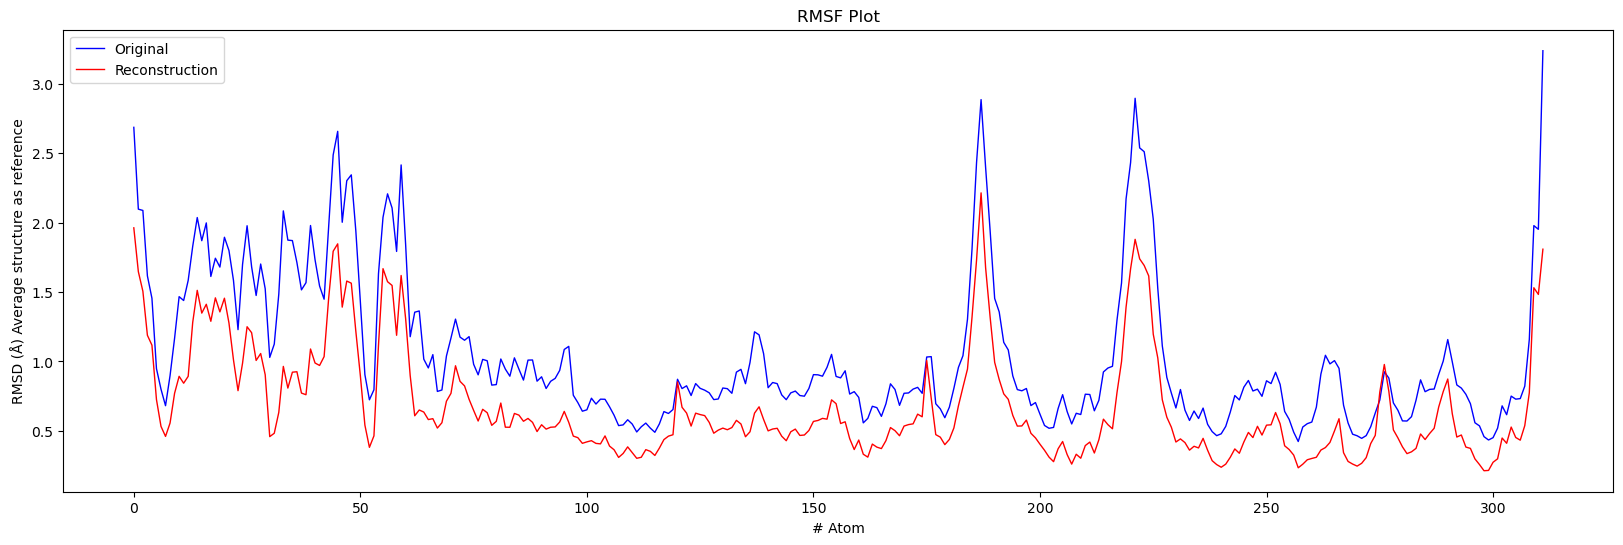

In [28]:
plots.plot_rmsf(original_traj_npy_file=input_data_npy_path, mutated_reconstructed_traj_npy_file=output_reconstructed_data_npy_path)

**RMSF difference plot** between **input** and **reconstructed trajectory** from an **autoencoder** visually **highlights** the **discrepancies** in **atomic fluctuations**, showcasing where the model may underrepresent or overrepresent the dynamic behavior of the **molecular dynamic simulation**. This comparison can pinpoint **specific areas** or **residues** of the structure that require improved modeling accuracy.

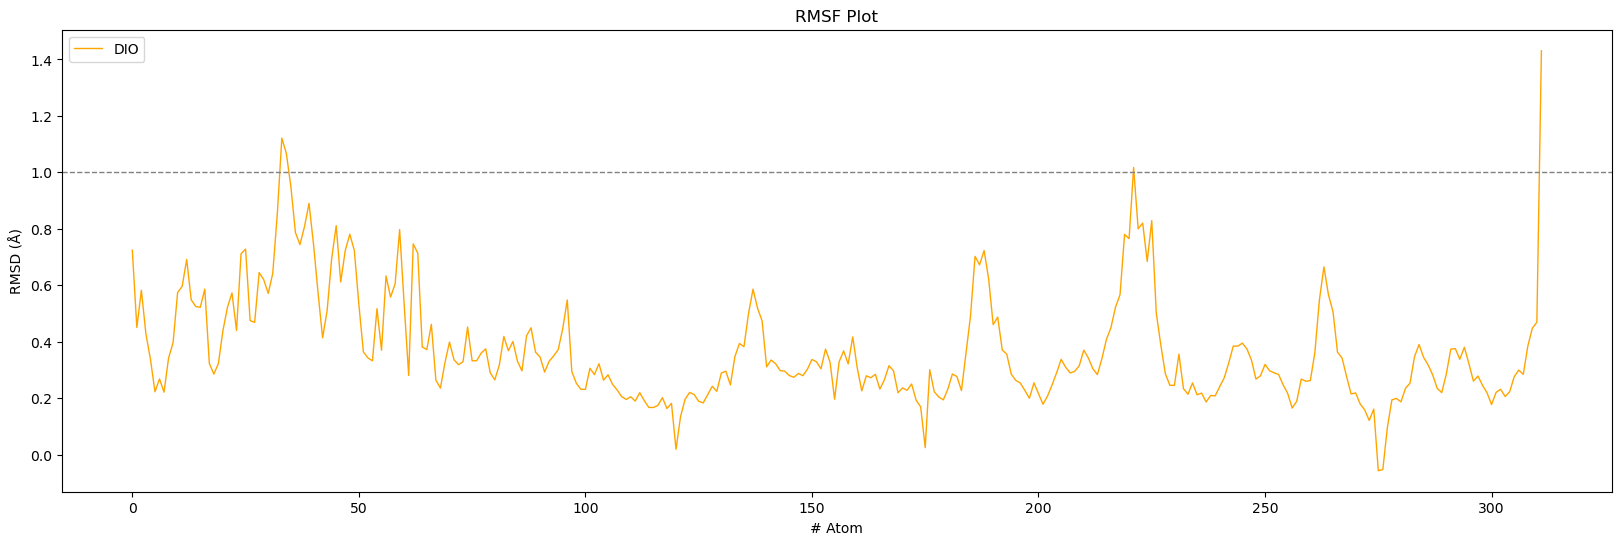

In [29]:
plots.plot_rmsf_difference(original_traj_npy_file=input_data_npy_path, mutated_reconstructed_traj_npy_file=output_reconstructed_data_npy_path)

***
<a id="questions"></a>

## Questions & Comments

Questions, issues, suggestions and comments are really welcome!

* GitHub issues:
    * [https://github.com/bioexcel/biobb](https://github.com/bioexcel/biobb)

* BioExcel forum:
    * [https://ask.bioexcel.eu/c/BioExcel-Building-Blocks-library](https://ask.bioexcel.eu/c/BioExcel-Building-Blocks-library)
